https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/convert/python_api.md

https://www.tensorflow.org/lite/microcontrollers/build_convert

1. Train model using Tensorflow Lite
2. Convert to microcontroller version
3. Deploy on Raspberry Pi

Possible Datasets:
https://www.kaggle.com/inIT-OWL/high-storage-system-data-for-energy-optimization,
https://www.kaggle.com/tocha4/predictive-maintenance-basics-about-dataset,
https://www.kaggle.com/inIT-OWL/one-year-industrial-component-degradation, http://odds.cs.stonybrook.edu/

Technique:
https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/

## Setup

### Install Tensorflow
Note: TF 1.13 and above requires CUDA 10. If no NVidia GPU is available, install tensorflow-cpu instead
- https://www.tensorflow.org/install/gpu
- https://developer.nvidia.com/cuda-10.1-download-archive

```
conda install tensorflow-gpu
```

### Install other libraries:
```
conda install pandas matplotlib scikit-learn
pip install --user --upgrade tensorflow-probability
```

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_probability as tfp

from timeit import default_timer as timer

## Data Exploration

In [9]:
df = pd.read_csv('./../data/versatileproductionsystem/Filling_ALL.module.csv', index_col=0)
df.head()

,I_BottleAtAirpipe,I_BottleClampClose,I_BottleClampOpen,I_BottleGateClosed,I_BottleReserveGateClosed,I_BottlesAvailable,I_BottleSlot1,I_BottleSlot2_H2O,I_BottleSlot3_Corn,I_BottleSlot5_CapOn,...,BottlesAvailable.AnalogValue.EURangeViolation,BottleSlot1.AnalogValue.EURangeViolation,BottleSlot2_H2O.AnalogValue.EURangeViolation,BottleSlot3_Corn.AnalogValue.EURangeViolation,BottleSlot5_CapOn.AnalogValue.EURangeViolation,BottleSlot6_CapCloser.AnalogValue.EURangeViolation,BottleSlot8_ModuleOut.AnalogValue.EURangeViolation,BottlesNotUsed.AnalogValue.EURangeViolation,UltraSonic_Corn.DistanceM.EURangeViolation,UltraSonic_H2O.DistanceM.EURangeViolation
Timestamp,,,,,,,,,,,,,,,,,,,,,
1529500027127,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027227,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027327,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027428,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1529500027528,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10529 entries, 1529500027127 to 1529501082130
Data columns (total 84 columns):
I_BottleAtAirpipe                                     10529 non-null int64
I_BottleClampClose                                    10529 non-null int64
I_BottleClampOpen                                     10529 non-null int64
I_BottleGateClosed                                    10529 non-null int64
I_BottleReserveGateClosed                             10529 non-null int64
I_BottlesAvailable                                    10529 non-null int64
I_BottleSlot1                                         10529 non-null int64
I_BottleSlot2_H2O                                     10529 non-null int64
I_BottleSlot3_Corn                                    10529 non-null int64
I_BottleSlot5_CapOn                                   10529 non-null int64
I_BottleSlot6_CapScrewer                              10529 non-null int64
I_BottleSlot8_Output                          

In [11]:
df.describe()

,I_BottleAtAirpipe,I_BottleClampClose,I_BottleClampOpen,I_BottleGateClosed,I_BottleReserveGateClosed,I_BottlesAvailable,I_BottleSlot1,I_BottleSlot2_H2O,I_BottleSlot3_Corn,I_BottleSlot5_CapOn,...,BottlesAvailable.AnalogValue.EURangeViolation,BottleSlot1.AnalogValue.EURangeViolation,BottleSlot2_H2O.AnalogValue.EURangeViolation,BottleSlot3_Corn.AnalogValue.EURangeViolation,BottleSlot5_CapOn.AnalogValue.EURangeViolation,BottleSlot6_CapCloser.AnalogValue.EURangeViolation,BottleSlot8_ModuleOut.AnalogValue.EURangeViolation,BottlesNotUsed.AnalogValue.EURangeViolation,UltraSonic_Corn.DistanceM.EURangeViolation,UltraSonic_H2O.DistanceM.EURangeViolation
count,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,10529.000000,...,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0,10529.0
mean,0.011207,0.254155,0.716497,0.973597,0.994871,0.973977,0.004274,0.688100,0.692089,0.712603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.105274,0.435406,0.450720,0.160339,0.071434,0.159212,0.065238,0.463291,0.461652,0.452570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# filter out low variance columns and plot them
high_variance_cols = df.columns[df.std() > 0.25]

high_variance_cols

Index(['I_BottleClampClose', 'I_BottleClampOpen', 'I_BottleSlot2_H2O',
       'I_BottleSlot3_Corn', 'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_BottlesReserveAvailable', 'I_CapGrabberUp', 'I_CapScrewer_Up',
       'I_CapScrewerClosePos', 'I_CapScrewerGrabClosed', 'I_CapScrewerOpenPos',
       'I_LinAxisCapInGrabber', 'I_LinAxisDown', 'I_LinAxisEmptyGrabber',
       'I_LinAxisUp', 'I_Pump_Down', 'I_RotaryTablePosReached',
       'I_UltrasonicCorn', 'I_UltrasonicCorn_Distance',
       'I_UltrasonicH2O_Distance', 'O_BottleClampClose',
       'O_CapGrabberOpenClose', 'O_CapGrabberUpDown', 'O_CapScrewDown',
       'O_CapScrewerGrabberOpenClose', 'O_CloseCap', 'O_ConveyorCapsForward',
       'O_LinAxisUpDown', 'O_PumpUpDown', 'O_RotaryTable',
       'O_ValvePumpCloseOpen', 'PendingOrder', 'Rotating', 'State',
       'BottlesAvailable', 'BottleSlot1', 'BottleSlot2_H2O',
       'BottleSlot3_Corn', 'BottleSlot5_CapOn', 'BottleSlot6_CapCloser',
       'BottleSlot8_ModuleOut', 'B

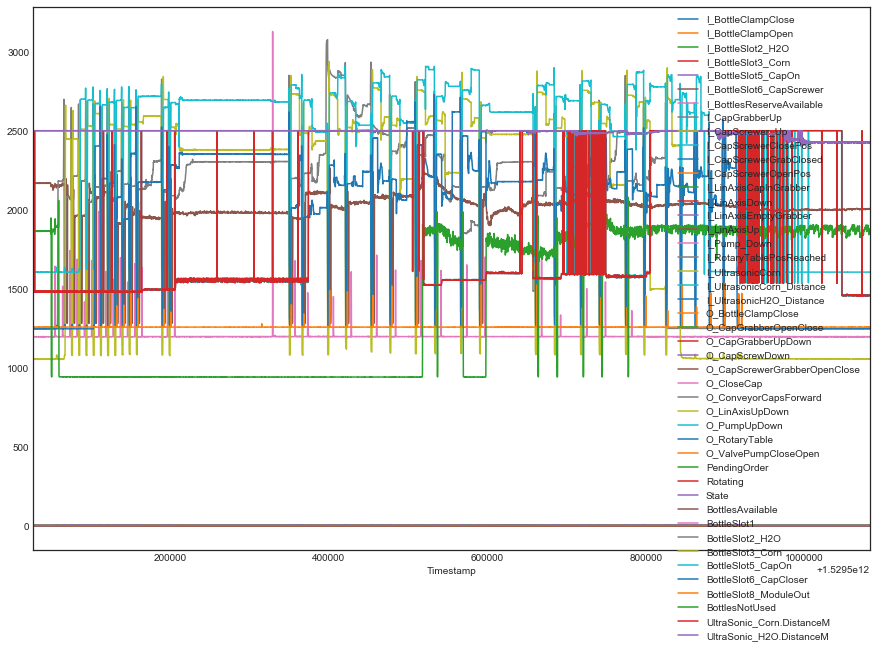

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
df[high_variance_cols].plot(ax=ax)
plt.show()

In [14]:
# There are still columns with low mean, let's plot them

df1 = df[high_variance_cols]
low_mean_cols = df1.columns[df1.mean() < 5]
low_mean_cols

Index(['I_BottleClampClose', 'I_BottleClampOpen', 'I_BottleSlot2_H2O',
       'I_BottleSlot3_Corn', 'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_BottlesReserveAvailable', 'I_CapGrabberUp', 'I_CapScrewer_Up',
       'I_CapScrewerClosePos', 'I_CapScrewerGrabClosed', 'I_CapScrewerOpenPos',
       'I_LinAxisCapInGrabber', 'I_LinAxisDown', 'I_LinAxisEmptyGrabber',
       'I_LinAxisUp', 'I_Pump_Down', 'I_RotaryTablePosReached',
       'I_UltrasonicCorn', 'O_BottleClampClose', 'O_CapGrabberOpenClose',
       'O_CapGrabberUpDown', 'O_CapScrewDown', 'O_CapScrewerGrabberOpenClose',
       'O_CloseCap', 'O_ConveyorCapsForward', 'O_LinAxisUpDown',
       'O_PumpUpDown', 'O_RotaryTable', 'O_ValvePumpCloseOpen', 'PendingOrder',
       'Rotating', 'State'],
      dtype='object')

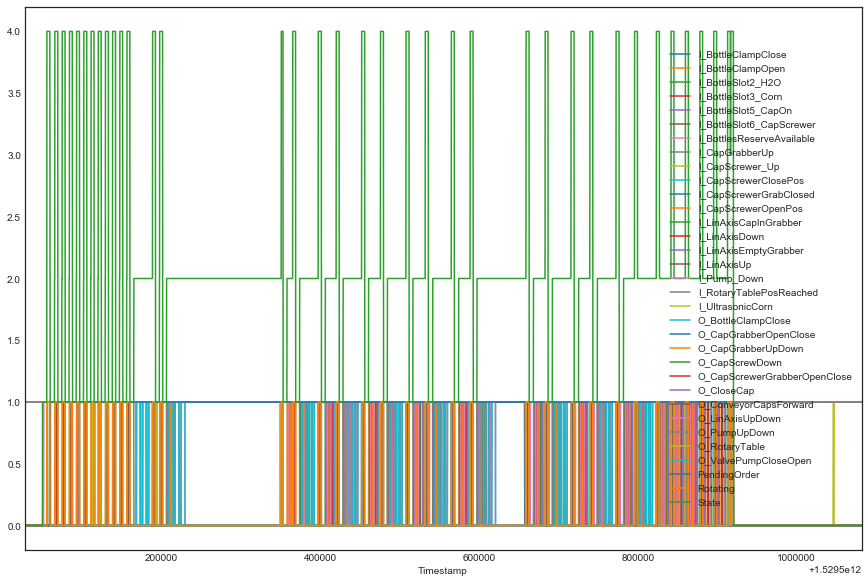

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
df1[low_mean_cols].plot(ax=ax)
plt.show()

In [16]:
# these are the high mean columns
high_mean_cols = set(df1.columns).difference(low_mean_cols)
high_mean_cols

{'BottleSlot1',
 'BottleSlot2_H2O',
 'BottleSlot3_Corn',
 'BottleSlot5_CapOn',
 'BottleSlot6_CapCloser',
 'BottleSlot8_ModuleOut',
 'BottlesAvailable',
 'BottlesNotUsed',
 'I_UltrasonicCorn_Distance',
 'I_UltrasonicH2O_Distance',
 'UltraSonic_Corn.DistanceM',
 'UltraSonic_H2O.DistanceM'}

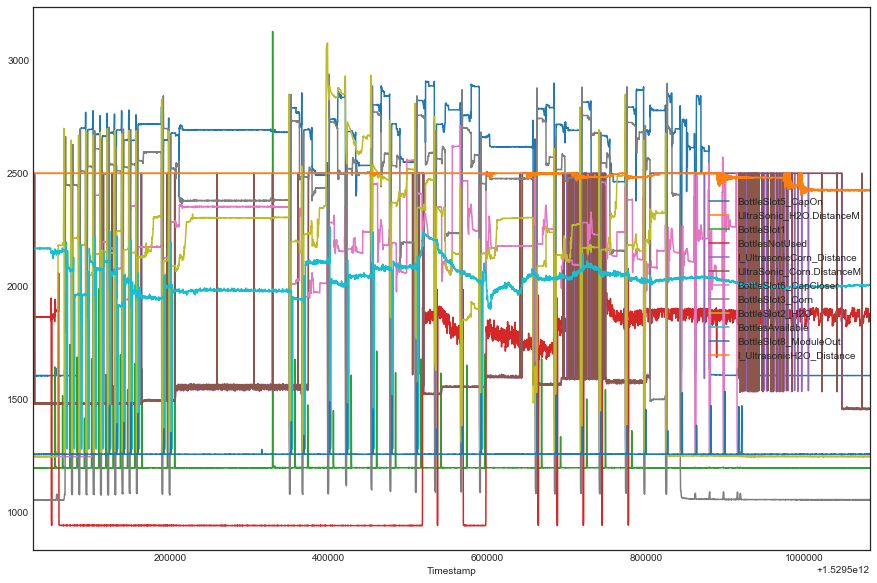

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
df1[high_mean_cols].plot(ax=ax)
plt.show()

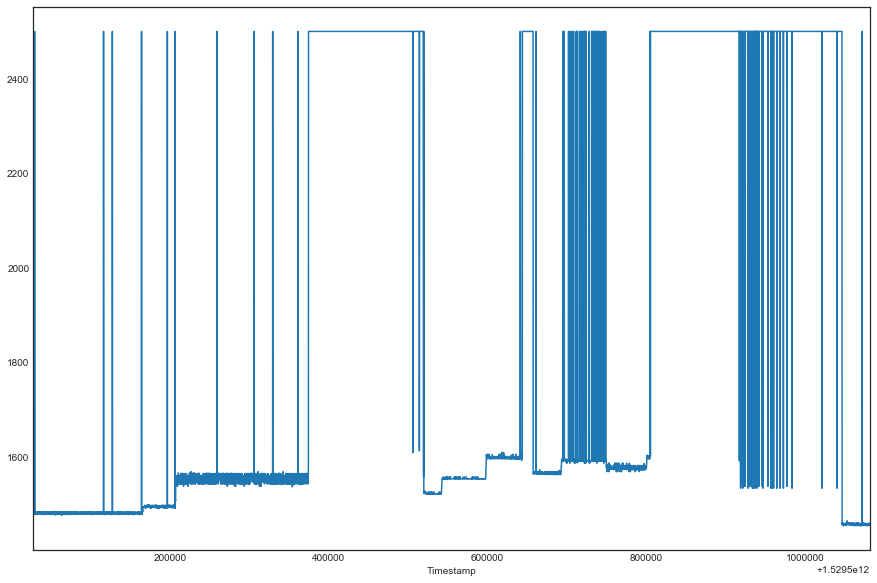

In [18]:
# pick one of the variables to do anomaly detection

fig, ax = plt.subplots(figsize=(15, 10))
df1['UltraSonic_Corn.DistanceM'].plot(ax=ax)
plt.show()

C:\Users\issohl\.conda\envs\diec\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\.conda\envs\diec\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


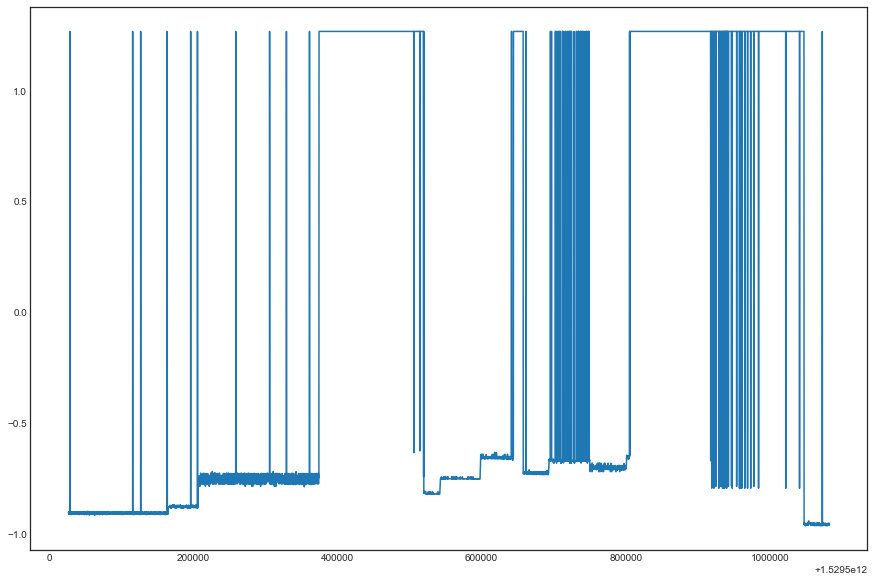

In [19]:
# scale and plot again. Scaling will 
scaler = StandardScaler()
scaled_df1 = scaler.fit_transform(df1)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df1.index, scaled_df1[:, df1.columns == 'UltraSonic_Corn.DistanceM'])
plt.show()

## Time Series windowing

In [77]:
# How ds.window works
# https://stackoverflow.com/questions/55109817/batch-sequential-data-with-tf-data
# https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0

# window_size = 3
# batch_size = 10
data = tf.data.Dataset.from_tensor_slices(([1, 2, 3, 4, 5, 111, 222, 333, 444, 555]))\
                .window(3, 1, drop_remainder=True) \
                .flat_map(lambda x: x.batch(3))\
                .repeat(-1)\
                .batch(10)
data_it = data.make_initializable_iterator()
next_element = data_it.get_next()

with tf.Session() as sess:
    sess.run(data_it.initializer)
    print(sess.run(next_element))

[[  1   2   3]
 [  2   3   4]
 [  3   4   5]
 [  4   5 111]
 [  5 111 222]
 [111 222 333]
 [222 333 444]
 [333 444 555]
 [  1   2   3]
 [  2   3   4]]


## Model

This is copied from https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/, with an update to make windowed inputs.

In [144]:
class VAE(object):
    def __init__(self, z_dim, n_dim, n_hidden_layers):
        tf.reset_default_graph()
        
        def make_prior(code_size):
            loc = tf.zeros(code_size)
            scale = tf.ones(code_size)
            return tfp.distributions.MultivariateNormalDiag(loc, scale)
        
        self.z_dim = z_dim
        self.n_dim = n_dim
        self.dense_size = n_hidden_layers
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='target_data')
        self.batch_size = tf.placeholder(dtype=tf.int64, name='init_batch_size')
        
        # create windows, infinitely, and batch them up
        dataset = tf.data.Dataset.from_tensor_slices(self.input) \
            .window(size=self.n_dim, shift=1) \
            .flat_map(lambda x: x.batch(self.n_dim)) \
            .repeat(-1) \
            .batch(self.batch_size)
        self.ite = dataset.make_initializable_iterator()
        self.x = self.ite.get_next()
        
        # encoder
        self.prior = make_prior(code_size=self.z_dim)
        x = tf.layers.dense(self.x, self.dense_size, tf.nn.relu)
        x = tf.layers.dense(x, self.dense_size, tf.nn.relu)
        loc = tf.layers.dense(x, self.z_dim)
        scale = tf.layers.dense(x, self.z_dim, tf.nn.softplus)
        self.posterior = tfp.distributions.MultivariateNormalDiag(loc, scale)
        self.encoder = self.posterior.sample()
        
        # decoder
        x = self.encoder
        x = tf.layers.dense(x, self.dense_size, tf.nn.relu)
        x = tf.layers.dense(x, self.dense_size, tf.nn.relu)
        loc = tf.layers.dense(x, self.n_dim)
        scale = tf.layers.dense(x, self.n_dim, tf.nn.softplus)
        self.decoder = tfp.distributions.MultivariateNormalDiag(loc, scale)

        # loss
        self.likelihood = self.decoder.log_prob(self.x)
        self.divergence = tfp.distributions.kl_divergence(self.posterior, self.prior)
        self.elbo = tf.reduce_mean(self.likelihood - self.divergence)
        self.cost = -self.elbo # maximise ELBO by minimizing cost
        
        self.saver = tf.train.Saver()
        self.sess = tf.Session()
        
    def fit(self, X, learning_rate=0.001, num_epochs=10, batch_size=10, verbose=True):
        self.optimize = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

        batches_per_epoch = len(X) // (batch_size * self.n_dim)
        print('Training anomaly detector/dimensionality reduction VAE')
        print(f'Batches per epoch: {batches_per_epoch}')
        start = timer()
        
        self.sess.run(tf.global_variables_initializer())
        self.min_loss = None
        self.losses = []
        
        for epoch in range(num_epochs):
            train_error = 0
            self.sess.run(
                self.ite.initializer,
                feed_dict = {self.input: X, self.batch_size: batch_size})
            
            for step in range(batches_per_epoch):
                _, loss = self.sess.run([self.optimize, self.cost])
                train_error += loss

                if step == (batches_per_epoch - 1):
                    mean_loss = train_error / batches_per_epoch
                    if self.min_loss is None or self.min_loss > mean_loss:
                        self.saver.save(self.sess, './models/vae_model', global_step=epoch)
                        self.min_loss = mean_loss
                        self.losses.append(mean_loss)

                    if verbose:
                        print(f'Epoch {epoch+1} Loss {mean_loss:.5f}')
            
            if train_error == np.nan:
                return False
            
        end = timer()
        print(f'Training time: {end-start:.2f}s')        
        return True

### Training

In [135]:
y = scaled_df1[:, df1.columns == 'UltraSonic_Corn.DistanceM']
y_train, y_test = train_test_split(y, shuffle=False)

y_train.shape

(7896, 1)

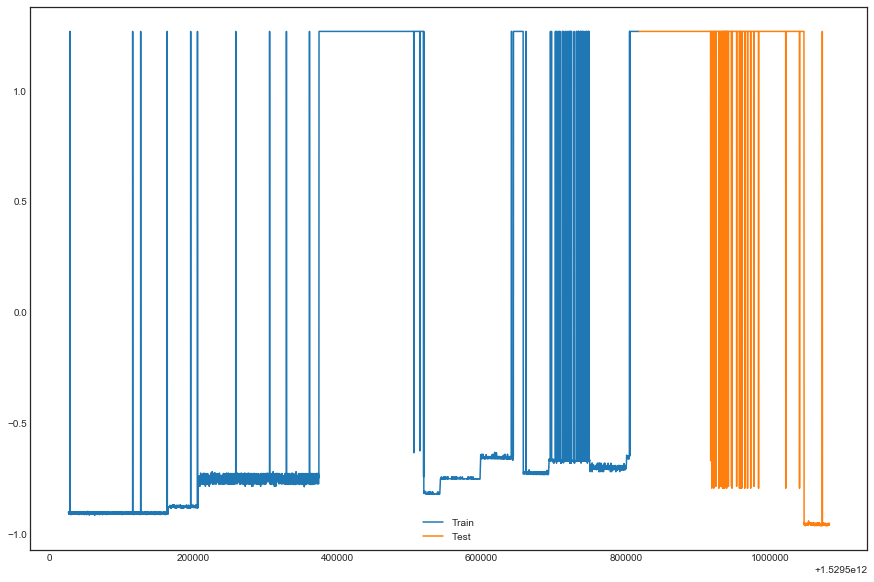

In [136]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df1.index[:y_train.shape[0]], y_train, label='Train')
ax.plot(df1.index[y_train.shape[0]:], y_test, label='Test')
ax.legend()
plt.show()

In [145]:
model = VAE(z_dim=20, n_dim=100, n_hidden_layers=20)
model.fit(y_train, num_epochs=20)

Training anomaly detector/dimensionality reduction VAE
Batches per epoch: 7
Epoch 1 Loss 142.46235
Epoch 2 Loss 135.93307
Epoch 3 Loss 129.68284
Epoch 4 Loss 123.05473
Epoch 5 Loss 115.31598
Epoch 6 Loss 106.33594
Epoch 7 Loss 96.51897
Epoch 8 Loss 86.75237
Epoch 9 Loss 78.82343
Epoch 10 Loss 69.89213
Epoch 11 Loss 61.03850
Epoch 12 Loss 52.64018
Epoch 13 Loss 43.96089
Epoch 14 Loss 35.01350
Epoch 15 Loss 26.37587
Epoch 16 Loss 16.06304
Epoch 17 Loss 6.28013
Epoch 18 Loss -5.10335
Epoch 19 Loss -16.95749
Epoch 20 Loss -29.02670
Training time: 15.98s


True

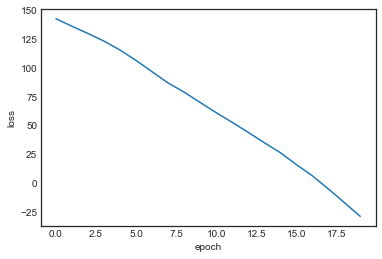

In [148]:
fig, ax = plt.subplots()
ax.plot(model.losses)
ax.set(xlabel='epoch', ylabel='loss')
plt.show()

### Prediction

In [140]:
model.sess.run(pred, feed_dict={model.input:y_train})

#                feed_dict = {self.input: X, self.batch_size: batch_size})


NameError: name 'pred' is not defined